# Data Cleaning

This notebook is another attempt on data cleaning on May 22nd, 2021

In [28]:
import os
import re
import spacy
import typing
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(1)
%matplotlib inline

## 1. Read the data

In [2]:
PROJECT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(PROJECT_DIR, 'data')

csv_file = os.path.join(DATA_DIR, 'amazon-product-reviews', 'Reviews.csv')

In [5]:
df = pd.read_csv(csv_file, encoding='latin-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
duplicated = df[df.duplicated(subset=['Text'])]
duplicated.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
574,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
603,604,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,1,1,5,1229385600,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
1973,1974,B0017165OG,A2EPNS38TTLZYN,tedebear,0,0,3,1312675200,Pok Chops,The pork chops from Omaha Steaks were very tas...
2309,2310,B0001VWE0M,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...
2323,2324,B0001VWE0C,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...
2336,2337,B0001FQVCK,A5D06XJHDXK75,C. Po,1,1,5,1190592000,"Baci's are pure heaven - great gift, stocking ...",My family has been in love with Baci's ever si...
2647,2648,B0016FY6H6,A2NLZ3M0OJV9NX,Mark Bodzin,0,0,2,1313107200,way too weak for my tastes,"What can i say, I love iced tea. I drink a lot..."
2653,2654,B0016FY6H6,A3I4PCBRENJNG2,L. Cain,0,0,4,1300579200,quality lightly sweetened green tea powder,lots of uses for this green tea...<br /><br />...
2946,2947,B0002TJAZK,A2ISKAWUPGGOLZ,M. S. Handley,0,1,1,1310774400,Kitty Junk Food,We have five cats - one an elderly cat of 15 y...


## 2. Cleaning

### 2.1. Deduplication of `Text`

In the original dataset, there seems to have many duplications of a same Text

In [9]:
df.drop_duplicates(subset=['Text'], inplace=True)  # dropping duplicates
df.dropna(axis=0, inplace=True)  # dropping na
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393565 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      393565 non-null  int64 
 1   ProductId               393565 non-null  object
 2   UserId                  393565 non-null  object
 3   ProfileName             393565 non-null  object
 4   HelpfulnessNumerator    393565 non-null  int64 
 5   HelpfulnessDenominator  393565 non-null  int64 
 6   Score                   393565 non-null  int64 
 7   Time                    393565 non-null  int64 
 8   Summary                 393565 non-null  object
 9   Text                    393565 non-null  object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


### 2.2. Clean words

In [10]:
contractions = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have",
    "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would",
    "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have",
    "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
    "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
    "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
    "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are",
    "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
    "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
    "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"
}

Get a list of common English **stop words**

I'm using NLTK stopwords instead of Spacy stopwords because I think Spacy's list contains way more words which might be helpful for our problem

In [21]:
stopwords = set(stopwords.words('english'))
len(stopwords)

179

**Helper function to clean text**

In [30]:
def clean_text(text: str, num: int) -> str:
    text = text.lower().strip().replace('\n', '')
    text = BeautifulSoup(text, 'lxml').text  # Remove HTML tags
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub('"','', text)
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])    
    text = re.sub(r"'s\b","", text)
    text = re.sub("[^a-zA-Z]", " ", text) 
    text = re.sub('[m]{2,}', 'mm', text)

    if(num == 0):
        tokens = [w for w in text.split() if not w in stopwords]
    else:
        tokens = text.split()

    long_words = [tok for tok in tokens if len(tok) > 1]
    return (" ".join(long_words)).strip()

Sanity check for the `clean_text` function

In [27]:
data = df[['Text', 'Summary']]
data.head(5)

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


**Clean the texts of all records in the dataset**

In [31]:
cleaned_text = []
for t in tqdm(data['Text']):
    cleaned_text.append(clean_text(t, 0))

100%|██████████| 393565/393565 [01:05<00:00, 6051.48it/s]


In [32]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [33]:
cleaned_summary = []
for t in tqdm(data['Summary']):
    cleaned_summary.append(clean_text(t, 0))

 16%|█▌        | 62651/393565 [00:07<00:37, 8743.45it/s]/home/erik/.cache/pypoetry/virtualenvs/dd2424-text-summarization-GSmT3uUC-py3.8/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
 31%|███       | 122835/393565 [00:14<00:31, 8717.57it/s]/home/erik/.cache/pypoetry/virtualenvs/dd2424-text-summarization-GSmT3uUC-py3.8/lib/python3.8/site-packages/bs4/__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
 39%|███▉      | 155126/393565 [00:17<00:28, 8510.87it/s]/home/erik/.cache/pypoetry/virtualenvs/dd2424-text-summarization-GSmT3uUC-py3.8/lib/python3.8/site-

In [34]:
cleaned_summary[:5]

['good quality dog food',
 'advertised',
 'delight says',
 'cough medicine',
 'great taffy']

Set the `data` frame to use the cleaned texts

In [35]:
data['Text'] = cleaned_text
data['Summary'] = cleaned_summary

<ipython-input-35-bce07196deef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Text'] = cleaned_text
<ipython-input-35-bce07196deef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Summary'] = cleaned_summary


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393565 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Text     393565 non-null  object
 1   Summary  393565 non-null  object
dtypes: object(2)
memory usage: 9.0+ MB


**Another round of deduplication**

This is to remove text or summary that are potentially empty

In [37]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392324 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Text     392324 non-null  object
 1   Summary  392324 non-null  object
dtypes: object(2)
memory usage: 9.0+ MB


/home/erik/.cache/pypoetry/virtualenvs/dd2424-text-summarization-GSmT3uUC-py3.8/lib/python3.8/site-packages/pandas/core/frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-37-1bf572797fb1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(axis=0, inplace=True)


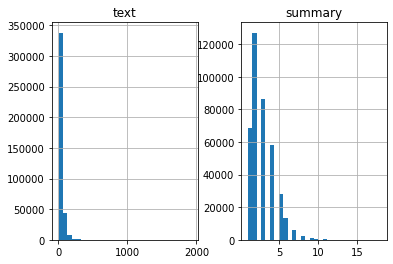

In [38]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['Text']:
      text_word_count.append(len(i.split()))

for i in data['Summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show();

#### Self-doubt

I'm interested in who much of the text in the dataset that is roughly longer than 64 words

In [43]:
cnt = 0
for i in data['Text']:
    if(len(i.split()) <= 64):
        cnt = cnt + 1
print(cnt/len(data['Text']))

0.8613441951040467


### 2.3. Standardize text lengths

In this step, we're going to standardize the length of the `Text` (i.e., `input`) to 64 and the `Summary` to 10

In [46]:
cleaned_text = np.array(data['Text'])
cleaned_summary = np.array(data['Summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= 8 and len(cleaned_text[i].split()) <= 64):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df = pd.DataFrame({ 'text': short_text, 'summary': short_summary })
df.head(5)

,text,summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,advertised
2,confection around centuries light pillowy citr...,delight says
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


## 3. Write output

In [55]:
df.to_csv(os.path.join(DATA_DIR, 'amazon-product-reviews', 'reviews-clean.csv'), index=False)